In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np 
import pandas as pd
import gymnasium as gym
import random
import math
import matplotlib.pyplot as plt
import import_ipynb
from collections import namedtuple

from Buffer import Experience
from Buffer import ReplayMemory
from Model import Agent

importing Jupyter notebook from Buffer.ipynb
importing Jupyter notebook from Model.ipynb


In [2]:
def train(agent: Agent, episodes):
    '''
        Trains the agent.
        args:
            Agent to train.
            episodes: Number of episodes to train the agent.
    '''
    losses = []
    ep_losses = []
    ep_reward = []
    
    steps_done = 0

    for k in range(episodes):
            
        # Starts envi.
        state, info = agent.env.reset()
        done = False
    
        # Statistics.
        total_reward = 0
    
        while not done:
            steps_done += 1
            # Get decayed epsilon.
            e = agent.decay(time=k, N_0=epsilon, decay_rate=decay_rate)
                
            action = agent.select_action(state, epsilon)
            next_state, reward, done, _, _ = agent.env.step(action)
            total_reward += reward

            # Creates and saves the experience inside Replay Memory.
            exp = Experience(state, action, reward, next_state, done)
            agent.rm.push(exp)

            # Optimization done at every step.
            loss = agent.learn()
            ep_losses.append(loss)

            # Target copy.
            if steps_done%4 == 0:
                agent.network_copy()

            state = next_state

        # Trajectory reward.
        ep_reward.append(total_reward)
        
        if k%10 == 0:
            avg_reward = int(sum(ep_reward)/len(ep_reward))
            # Average.
            avg_loss = int(sum(ep_losses)/len(ep_losses))
            losses.append(avg_loss)
            print(f'Episode:{k} Reward:{avg_reward}')
    return losses

Epsilon after 120 episodes is 0.1
Episode:0 Reward:9
Episode:10 Reward:9
Episode:20 Reward:9
Episode:30 Reward:9
Episode:40 Reward:11
Episode:50 Reward:11
Episode:60 Reward:21
Episode:70 Reward:39
Episode:80 Reward:58
Episode:90 Reward:81
Episode:100 Reward:94
Episode:110 Reward:105


NameError: name 'k' is not defined

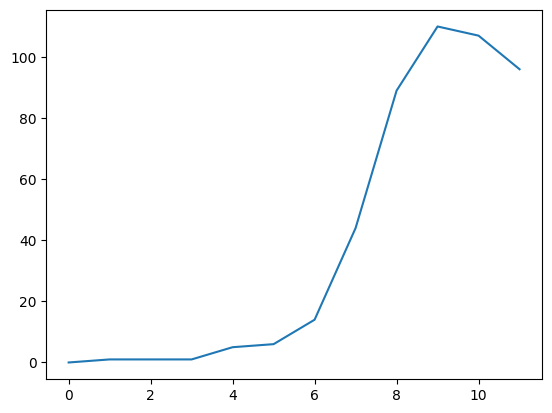

In [14]:
if __name__ == '__main__':
    learning_rate = 1e-3
    buffer_size = 50000
    batch_size = 16
    discount_rate = 0.99
    C = 5
    env = gym.make('CartPole-v1')
    
    a = Agent(env, 4, env.action_space.n, learning_rate, 128, buffer_size, discount_rate, C, batch_size)
    
    epsilon = 0.1
    decay_rate = 0 # No decay has been applied, but around 0.005 can be used.
    episodes = 120 # Use a number%10 == 0.
    print(f'Epsilon after {episodes} episodes is {a.decay(episodes, epsilon, decay_rate)}')

    losses = train(a, episodes)
    # Plot loss.
    plt.plot(range(int(episodes/10)), losses)

    # Empties the memory.
    torch.cuda.empty_cache()

    # Evaluation.
    envi = gym.make('CartPole-v1', render_mode='human')
    state, info = envi.reset()
    done = False
    total_reward = 0
    while not done:
        # Epsilon = 0.
        action = a.select_action(state, 0)
        next_state, reward, done, _, _ = envi.step(action)
        total_reward += reward
    
        state = next_state
    
    print(f'Reward:{total_reward}')